This will explore the previously parsed Zooniverse annotated data.

In [1]:
data_file = './zooniverse/cleaned_zooniverse.csv' # cleaned zooniverse data

dir_api = './example_hists/LLM_outputs/chatgpt_api/'

# what about for fewshot?
dir_api_fewshot = './example_hists/LLM_outputs/chatgpt_api_fewshot2/'

# what about for mini model?
dir_api_mini = './example_hists/LLM_outputs/chatgpt_api_mini/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from glob import glob
import seaborn as sns

In [3]:
df = pd.read_csv(data_file)

In [4]:
df.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50


### Annotator 1

In [5]:
df_a1 = df[df['annotators']=='annotator1']

len(df_a1)

80

<Axes: xlabel='Ground Truth nGaussians', ylabel='Human nGaussians'>

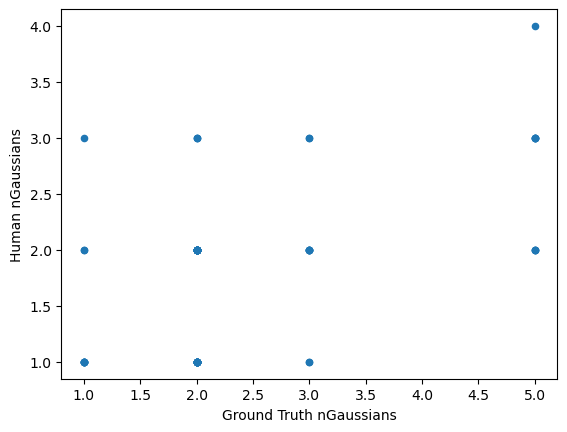

In [6]:
df_a1.plot(x='Ground Truth nGaussians', y='Human nGaussians', kind='scatter')

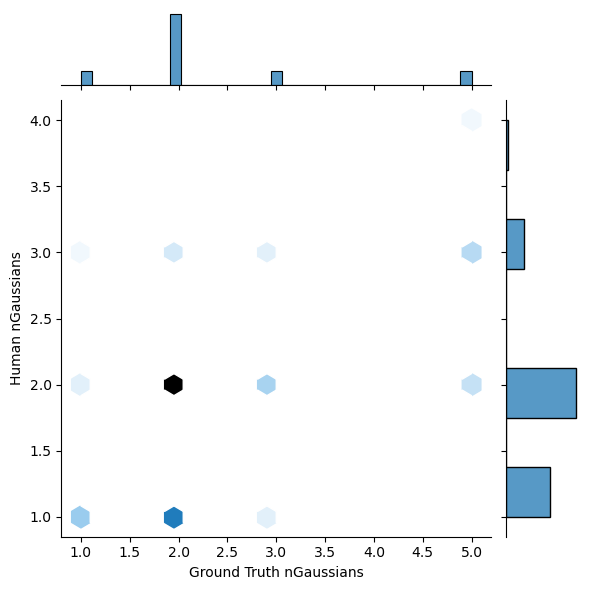

In [7]:
# a different way
sns.jointplot(x='Ground Truth nGaussians', y='Human nGaussians', data=df_a1, kind='hex')

(-0.8, 0.9)

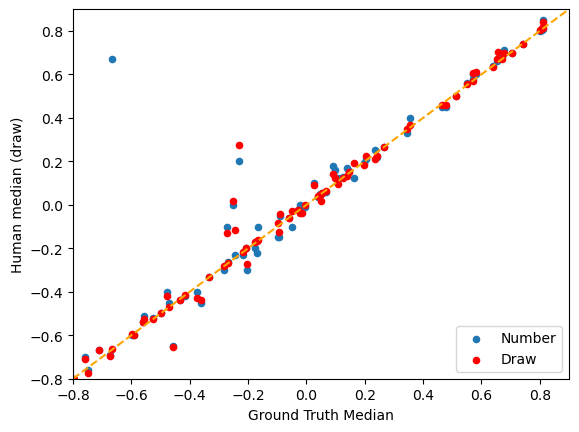

In [8]:
ax = df_a1.plot(x='Ground Truth Median', y='Human median (number)', kind='scatter', label='Number')
df_a1.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', label='Draw', ax=ax, color='red')

# so we can compare
mxmin = -0.8
mxmax = 0.9

# draw line of what it should be
ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [9]:
diff1 = (np.abs(df_a1['Ground Truth Median']-df_a1['Human median (draw)']))/np.abs(df_a1['Ground Truth Median'])

np.mean(diff1), np.std(diff1)

(0.19298121815362174, 0.42507057171782764)

In [10]:
q1 = np.percentile(diff1, 25)
q3 = np.percentile(diff1, 75)

iqr = q3 - q1

np.median(diff1), iqr

(0.0364671267337863, 0.11682488786479395)

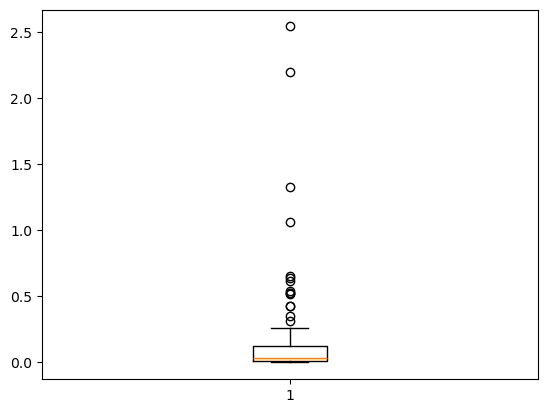

In [11]:
plt.boxplot(diff1)
plt.show()

### Annotator 2

In [12]:
df_a2 = df[df['annotators']=='annotator2']

len(df_a2)

80

<Axes: xlabel='Ground Truth nGaussians', ylabel='Human nGaussians'>

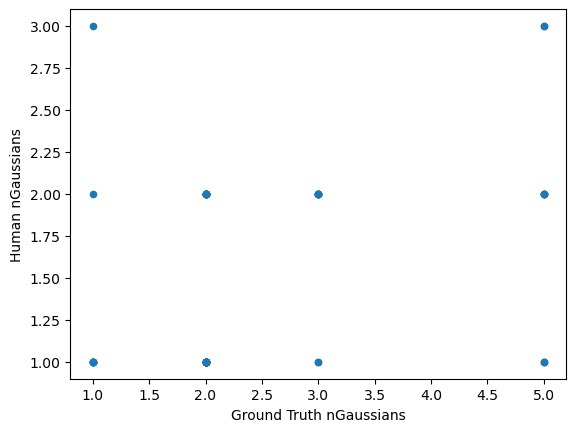

In [13]:
df_a2.plot(x='Ground Truth nGaussians', y='Human nGaussians', kind='scatter')

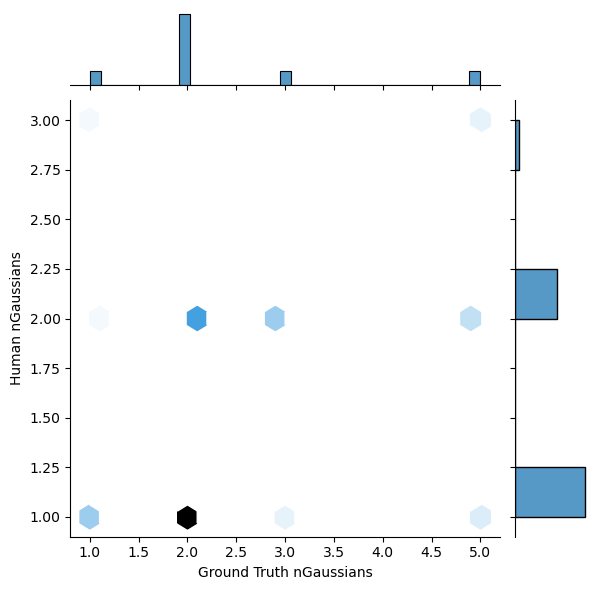

In [14]:
# a different way
sns.jointplot(x='Ground Truth nGaussians', y='Human nGaussians', data=df_a2, kind='hex')

(-0.8, 0.9)

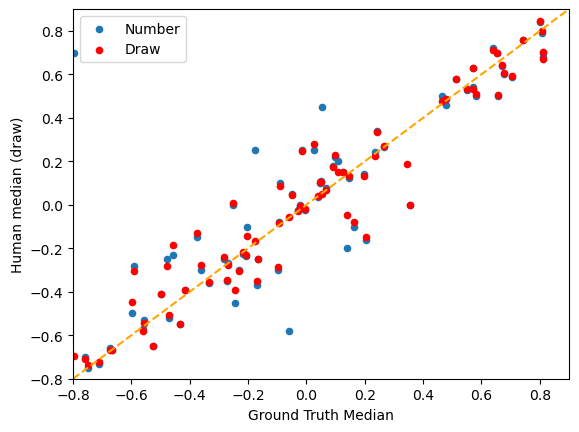

In [15]:
ax = df_a2.plot(x='Ground Truth Median', y='Human median (number)', kind='scatter', label='Number')
df_a2.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', label='Draw', ax=ax, color='red')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [16]:
diff2 = (np.abs(df_a2['Ground Truth Median']-df_a2['Human median (draw)']))/np.abs(df_a2['Ground Truth Median'])

np.mean(diff2), np.std(diff2)

(0.7191192015889002, 2.132788369224864)

In [17]:
q1 = np.percentile(diff2, 25)
q3 = np.percentile(diff2, 75)

iqr2 = q3 - q1

np.median(diff2), iqr2

(0.14713641903869362, 0.4655998981178578)

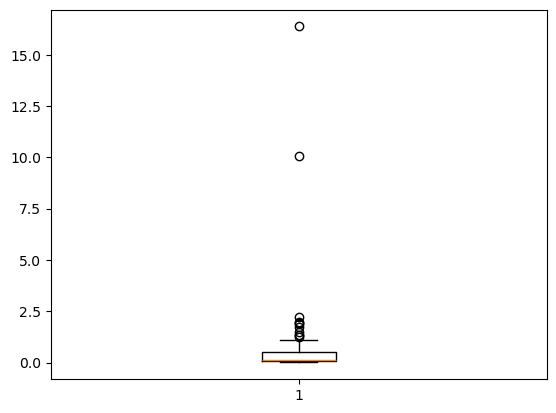

In [18]:
plt.boxplot(diff2)
plt.show()

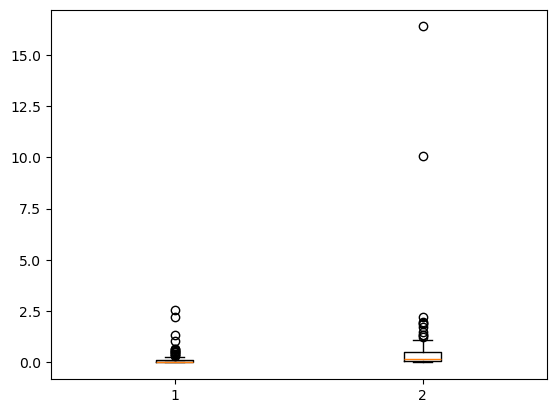

In [19]:
plt.boxplot([diff1,diff2])
plt.show()

## Compare to chatgpt (or other LLM)

In [20]:
df.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50


In [21]:
pickles = glob(dir_api + '*.pickle')
pickles[:3], len(pickles)

(['./example_hists/LLM_outputs/chatgpt_api/id_0039.pickle',
  './example_hists/LLM_outputs/chatgpt_api/id_0044.pickle',
  './example_hists/LLM_outputs/chatgpt_api/id_0027.pickle'],
 80)

In [22]:
dir_api

'./example_hists/LLM_outputs/chatgpt_api/'

In [34]:
# what to include in dataset
include_fewshot = False
include_mini = False

# names subset
pnames = []
for p in pickles:
    pn = p.split('/')[-1].removesuffix('.pickle') + '.jpeg'
    pnames.append(pn)

df2 = df.copy()[df['image file'].isin(np.array(pnames))]

#import sys; sys.exit()

llm_median = []
llm_ngaussian = []
llm_ngaussian_int = []
# fewshot
llm_median_fewshot = []
llm_ngaussian_fewshot = []
llm_ngaussian_int_fewshot = []
# mini
llm_median_mini = []
llm_ngaussian_mini = []
llm_ngaussian_int_mini = []

subset_questions_by_keys = [
    {
        'df flag':'LLM nGaussians',
        'question':'How many gaussians were used to generate the data for the plot in the figure panel?',
        'list':{'regular':llm_ngaussian, 'fewshot':llm_ngaussian_fewshot, 'mini':llm_ngaussian_mini}
    },
    {
        'question':'What is the median value of the data in this figure panel? ', #'What are the median data values  in this figure panel? ',
        'df flag':'LLM Median',
        'list':{'regular':llm_median, 'fewshot':llm_median_fewshot, 'mini':llm_median_mini}
    },
    {
        'df flag':'LLM nGaussians (int)',
        'question':'How many gaussians were used to generate the data for the plot in the figure panel?',
        'list':{'regular':llm_ngaussian_int, 'fewshot':llm_ngaussian_int_fewshot, 'mini':llm_ngaussian_int_mini}
    }
    ]
#import sys; sys.exit()
#['median', 'ngaussian'] # JPN: this is not efficient
# fill with LLM outputs
for i in range(len(df2)):
    #### W/O FEW SHOT #####
    pfile = dir_api + df2.iloc[i]['image file'].removesuffix('.jpeg') + '.pickle'
    with open(pfile, 'rb') as f:
        qa_in = pickle.load(f)[0]

    #import sys; sys.exit()

    #### WITH FEW SHOT #####
    pfile_fewshot = dir_api_fewshot + df2.iloc[i]['image file'].removesuffix('.jpeg') + '.pickle'
    with open(pfile_fewshot, 'rb') as f:
        qa_in_fewshot = pickle.load(f)[0]

    #### WITH MINI #####
    pfile_mini = dir_api_mini + df2.iloc[i]['image file'].removesuffix('.jpeg') + '.pickle'
    with open(pfile_mini, 'rb') as f:
        qa_in_mini = pickle.load(f)[0]

    #import sys; sys.exit()

    for listtype, qa_intype in zip(['regular', 'fewshot', 'mini'], [qa_in, qa_in_fewshot, qa_in_mini]):
        for qa_pairs in qa_intype: # find right questions
            for subset in subset_questions_by_keys:
                if qa_pairs['question'] == subset['question']:
                    ans = qa_pairs['Response']
                    try:
                        v = list(ans.values())[0]
                        subset['list'][listtype].append(v)
                    except:
                        subset['list'][listtype].append(np.nan)

for subset in subset_questions_by_keys:
    df2[subset['df flag']] = subset['list']['regular']
    if include_fewshot:
        df2[subset['df flag'] + ' FewShot'] = subset['list']['fewshot']
    if include_mini:
        df2[subset['df flag'] + ' Mini'] = subset['list']['mini']

# just a few things
# medians
if include_fewshot:
    df2['LLM Median FewShot'] = df2['LLM Median FewShot'].astype('float')
df2['LLM Median'] = df2['LLM Median'].astype('float')
if include_mini:
    df2['LLM Median Mini'] = df2['LLM Median Mini'].astype('float')
# ints
df2['LLM nGaussians (int)'] = df2['LLM nGaussians (int)'].astype('int')
if include_fewshot:
    df2['LLM nGaussians (int) FewShot'] = df2['LLM nGaussians (int) FewShot'].astype('int')
if include_mini:
    df2['LLM nGaussians (int) Mini'] = df2['LLM nGaussians (int) Mini'].astype('int')

# save this extended thing somewhere
df2.to_csv('./human_and_llm_annotated_data.csv', index=False)

In [28]:
df2.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int)
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,0.055,1
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,0.485,3
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45,1,-0.420,1
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50,2,-0.600,2
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50,1,-0.050,1


In [29]:
# just do the part that is a single annotator
df2_a1 = df2[df2['annotators']=='annotator1']
len(df2_a1)

80

In [30]:
#df2_a1.head(n=3)

(-0.8, 0.9)

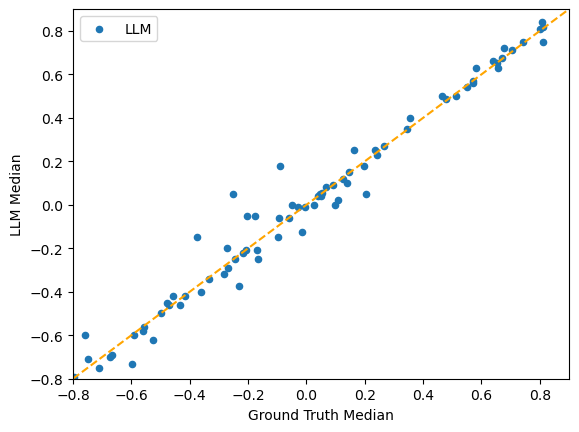

In [31]:
ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median', kind='scatter', label='LLM')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM Median']
    try:
        llmm = float(llmm)
    except:
        print("FAILED:", llmm)
        llmm = np.nan
    try:
        if np.isnan(llmm):
            gtm = df2_a1.iloc[i]['Ground Truth Median']
            ax.plot([gtm],[gtm], color='red', marker='X')
            #print(gtm)
    except:
        pass
        #print('THIS FAILED:', llmm)

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [35]:
if include_fewshot:
    ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median FewShot', kind='scatter', label='LLM FewShot')

    # so we can compare
    mxmin = -0.8
    mxmax = 0.9

    ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
    # plot NaNs
    for i in range(len(df2_a1)):
        llmm = df2_a1.iloc[i]['LLM Median FewShot']
        try:
            llmm = float(llmm)
        except:
            print("FAILED:", llmm)
            llmm = np.nan
        try:
            if np.isnan(llmm):
                gtm = df2_a1.iloc[i]['Ground Truth Median']
                ax.plot([gtm],[gtm], color='red', marker='X')
                #print(gtm)
        except:
            pass
            #print('THIS FAILED:', llmm)

    ax.set_ylim(mxmin,mxmax)
    ax.set_xlim(mxmin,mxmax)

In [37]:
if include_mini:
    ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median Mini', kind='scatter', label='LLM Mini')

    # so we can compare
    mxmin = -0.8
    mxmax = 0.9

    ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
    # plot NaNs
    for i in range(len(df2_a1)):
        llmm = df2_a1.iloc[i]['LLM Median Mini']
        try:
            llmm = float(llmm)
        except:
            print("FAILED:", llmm)
            llmm = np.nan
        try:
            if np.isnan(llmm):
                gtm = df2_a1.iloc[i]['Ground Truth Median']
                ax.plot([gtm],[gtm], color='red', marker='X')
                #print(gtm)
        except:
            pass
            #print('THIS FAILED:', llmm)

    ax.set_ylim(mxmin,mxmax)
    ax.set_xlim(mxmin,mxmax)

In [38]:
if include_mini:

    ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median Mini', kind='scatter', label='LLM Mini')

    ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
    # plot NaNs
    for i in range(len(df2_a1)):
        llmm = df2_a1.iloc[i]['LLM Median Mini']
        try:
            llmm = float(llmm)
        except:
            print("FAILED:", llmm)
            llmm = np.nan
        try:
            if np.isnan(llmm):
                gtm = df2_a1.iloc[i]['Ground Truth Median']
                ax.plot([gtm],[gtm], color='red', marker='X')
                #print(gtm)
        except:
            pass

(-0.8, 0.9)

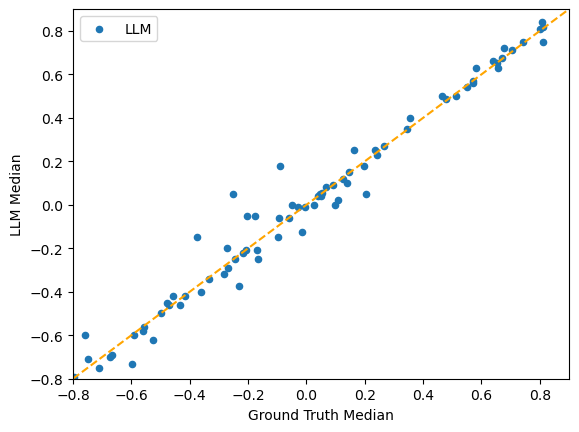

In [39]:
# on top of each other
ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median', kind='scatter', label='LLM')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM Median']
    try:
        llmm = float(llmm)
    except:
        print("FAILED:", llmm)
        llmm = np.nan
    try:
        if np.isnan(llmm):
            gtm = df2_a1.iloc[i]['Ground Truth Median']
            ax.plot([gtm],[gtm], color='red', marker='X')
            #print(gtm)
    except:
        pass
        #print('THIS FAILED:', llmm)


#### fewshot ####
if include_fewshot:
    df2_a1.plot(x='Ground Truth Median', y='LLM Median FewShot', kind='scatter', label='LLM FewShot', ax=ax, color='orange')

    ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
    # plot NaNs
    for i in range(len(df2_a1)):
        llmm = df2_a1.iloc[i]['LLM Median FewShot']
        try:
            llmm = float(llmm)
        except:
            print("FAILED:", llmm)
            llmm = np.nan
        try:
            if np.isnan(llmm):
                gtm = df2_a1.iloc[i]['Ground Truth Median']
                ax.plot([gtm],[gtm], color='red', marker='X')
                #print(gtm)
        except:
            pass
            #print('THIS FAILED:', llmm)


### mini ####
if include_mini:
    df2_a1.plot(x='Ground Truth Median', y='LLM Median Mini', kind='scatter', label='LLM Mini', ax=ax, color='cyan')

    ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
    # plot NaNs
    for i in range(len(df2_a1)):
        llmm = df2_a1.iloc[i]['LLM Median Mini']
        try:
            llmm = float(llmm)
        except:
            print("FAILED:", llmm)
            llmm = np.nan
        try:
            if np.isnan(llmm):
                gtm = df2_a1.iloc[i]['Ground Truth Median']
                ax.plot([gtm],[gtm], color='red', marker='X')
                #print(gtm)
        except:
            pass

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

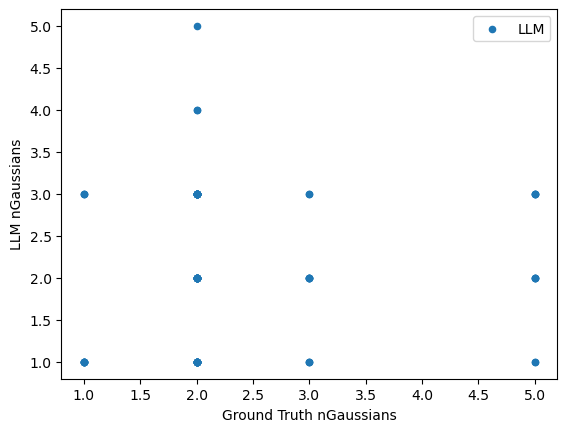

In [40]:
ax = df2_a1.plot(x='Ground Truth nGaussians', y='LLM nGaussians', kind='scatter', label='LLM')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM nGaussians']
    if np.isnan(llmm):
        gtm = df2_a1.iloc[i]['Ground Truth nGaussians']
        ax.plot([gtm],[gtm], color='red', marker='X')
        print(gtm)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

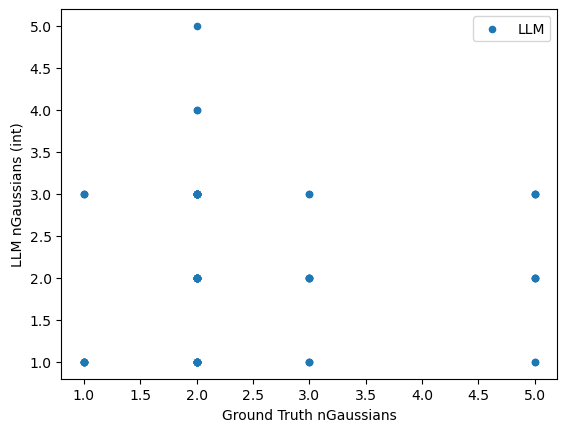

In [41]:
ax = df2_a1.plot(x='Ground Truth nGaussians', y='LLM nGaussians (int)', kind='scatter', label='LLM')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM nGaussians']
    if np.isnan(llmm):
        gtm = df2_a1.iloc[i]['Ground Truth nGaussians']
        ax.plot([gtm],[gtm], color='red', marker='X')
        print(gtm)

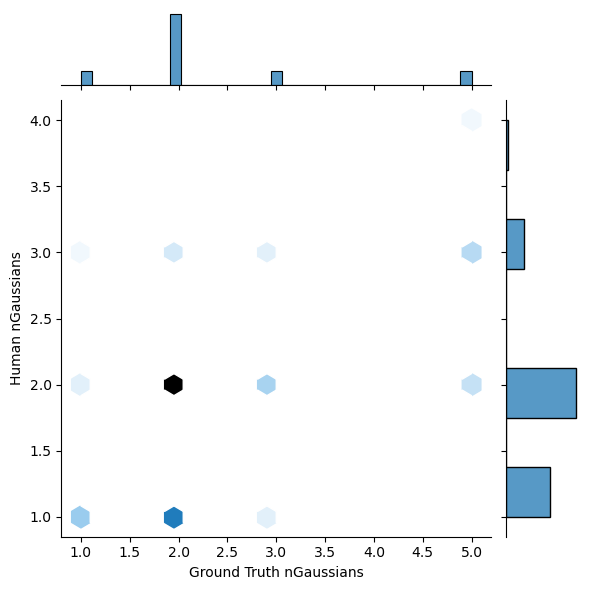

In [42]:
# a different way
sns.jointplot(x='Ground Truth nGaussians', y='Human nGaussians', data=df2_a1, kind='hex')

Some numbers:

In [43]:
diff_llm = (np.abs(df2_a1['Ground Truth Median']-df2_a1['LLM Median']))/np.abs(df2_a1['Ground Truth Median'])

diff_llm = diff_llm[~np.isnan(diff_llm.values)].values

np.mean(diff_llm), np.std(diff_llm)

(40.13789683191748, 353.92053627356006)

In [45]:
if include_fewshot:
    diff_llmfs = (np.abs(df2_a1['Ground Truth Median']-df2_a1['LLM Median FewShot']))/np.abs(df2_a1['Ground Truth Median'])

    diff_llmfs = diff_llmfs[~np.isnan(diff_llmfs.values)].values

    print(np.mean(diff_llmfs), np.std(diff_llmfs))

In [47]:
if include_mini:
    diff_llmm = (np.abs(df2_a1['Ground Truth Median']-df2_a1['LLM Median Mini']))/np.abs(df2_a1['Ground Truth Median'])

    diff_llmm = diff_llmm[~np.isnan(diff_llmm.values)].values

    print(np.mean(diff_llmm), np.std(diff_llmm))
    print('max:', diff_llmm.max())

So the issue is that there are a few very large ones.

In [48]:
q1 = np.percentile(diff_llm, 25)
q3 = np.percentile(diff_llm, 75)

iqrl = q3 - q1

np.median(diff_llm), iqrl

(0.05983064569954473, 0.2508702820457147)

In [50]:
if include_fewshot:
    q1 = np.percentile(diff_llmfs, 25)
    q3 = np.percentile(diff_llmfs, 75)

    iqrlfs = q3 - q1

    print(np.median(diff_llmfs), iqrlfs)

In [51]:
if include_mini:
    q1 = np.percentile(diff_llmm, 25)
    q3 = np.percentile(diff_llmm, 75)

    iqrlm = q3 - q1

    print(np.median(diff_llmm), iqrlm)

In [52]:
np.median(diff1), iqr

(0.0364671267337863, 0.11682488786479395)

### Human vs LLM

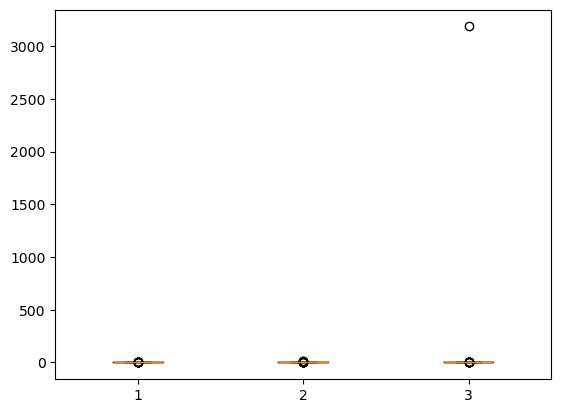

In [53]:
plt.boxplot([diff1,diff2,diff_llm])
plt.show()

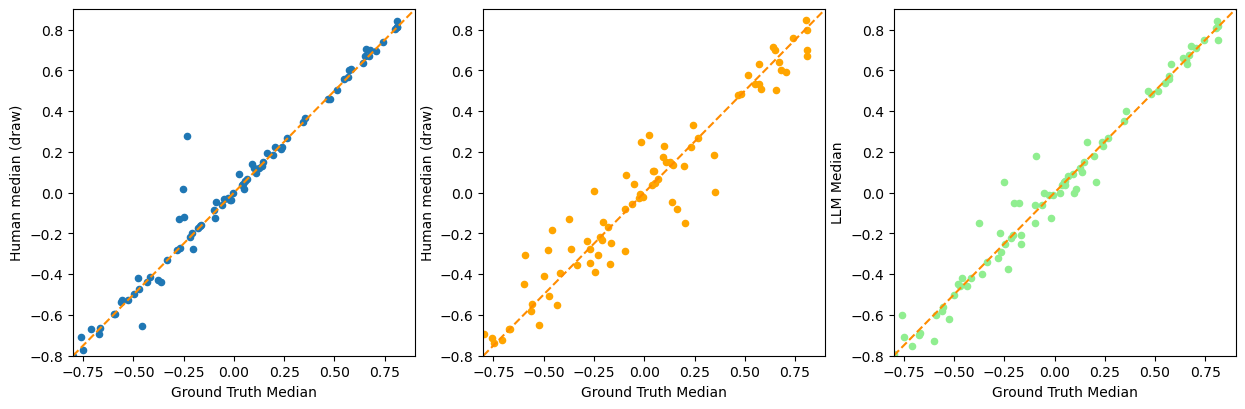

In [54]:
llm_color = 'lightgreen'
a1_color = 'tab:blue'
a2_color = 'orange'

llm_error_color = 'darkgreen'
llm_error_marker_size = 10

equal_line_color = 'darkorange'

base = 5
fig, ax = plt.subplots(1,3, figsize=(base*3,base*0.9))

############### ANNOTATOR 1 ###################

df_a1.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', ax=ax[0], color=a1_color)

############### ANNOTATOR 2 ###################

df_a2.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', ax=ax[1], color=a2_color)


##################### LLM #####################
#ax = 
df2_a1.plot(x='Ground Truth Median', y='LLM Median', kind='scatter', color=llm_color, ax=ax[2])



# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM Median']
    try:
        llmm = float(llmm)
    except:
        print("FAILED:", llmm)
        llmm = np.nan
    try:
        if np.isnan(llmm):
            gtm = df2_a1.iloc[i]['Ground Truth Median']
            ax[2].plot([gtm],[gtm], color=llm_error_color, marker='X', ms=llm_error_marker_size)
            #print(gtm)
    except:
        pass
        #print('THIS FAILED:', llmm)


# so we can compare
mxmin = -0.8
mxmax = 0.9
for a in ax:
    a.set_ylim(mxmin,mxmax)
    a.set_xlim(mxmin,mxmax)
    a.plot([mxmin,mxmax],[mxmin,mxmax], color=equal_line_color, linestyle='--')


## How does accuracy vary across different bar sizes?

```python
nparams = [
    {'nb':10, 'nc':2},
    {'nb':20, 'nc':2},
    {'nb':45, 'nc':2},
    {'nb':60, 'nc':2}, # updated so no overlap
    # different set
    {'nb':50, 'nc':1},
    {'nb':50, 'nc':2}, 
    {'nb':50, 'nc':3},
    {'nb':50, 'nc':5}
]
```

In [55]:
df2.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int)
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,0.055,1
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,0.485,3
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45,1,-0.420,1
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50,2,-0.600,2
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50,1,-0.050,1


### Median vs number of bars

In [56]:
dfbars = df2.copy()[df2['Ground Truth nBars'].isin([10,20,45,60])]
# make differences
diffa = np.abs(dfbars['Ground Truth Median']-dfbars['Human median (draw)'])
diffl = np.abs(dfbars['Ground Truth Median']-dfbars['LLM Median'])

dfbars['Diff Median (human)'] = diffa
dfbars['Diff Median (LLM)'] = diffl

In [57]:
dfbars.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int),Diff Median (human),Diff Median (LLM)
2,annotator1,id_0028.jpeg,2,-0.42,-0.415863,2,-0.417302,45,1,-0.42,1,0.001439,0.002698
5,annotator1,id_0023.jpeg,2,0.80,0.802035,2,0.802090,60,2,0.81,2,0.000055,0.007910
6,annotator1,id_0013.jpeg,1,-0.15,-0.085378,2,-0.097916,60,1,-0.15,1,0.012537,0.052084
7,annotator1,id_0074.jpeg,2,-0.40,-0.428922,2,-0.376166,45,2,-0.15,2,0.052756,0.226166
8,annotator1,id_0017.jpeg,1,0.74,0.738279,2,0.740846,45,1,0.75,1,0.002567,0.009154


In [58]:
da1 = dfbars[dfbars['annotators']=='annotator1']
da2 = dfbars[dfbars['annotators']=='annotator2']
dl = da1.copy()

In [59]:
da1[da1['Ground Truth nBars']==45]

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int),Diff Median (human),Diff Median (LLM)
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45,1,-0.42,1,0.001439,0.002698
7,annotator1,id_0074.jpeg,2,-0.400,-0.428922,2,-0.376166,45,2,-0.15,2,0.052756,0.226166
8,annotator1,id_0017.jpeg,1,0.740,0.738279,2,0.740846,45,1,0.75,1,0.002567,0.009154
11,annotator1,id_0079.jpeg,1,-0.010,-0.002272,2,-0.006342,45,1,-0.01,1,0.004070,0.003658
26,annotator1,id_0043.jpeg,2,0.125,0.094421,2,0.107690,45,2,0.02,2,0.013269,0.087690
27,annotator1,id_0060.jpeg,2,-0.600,-0.593485,2,-0.598682,45,2,-0.73,2,0.005197,0.131318
42,annotator1,id_0024.jpeg,2,-0.100,-0.129759,2,-0.271708,45,2,-0.20,2,0.141949,0.071708
56,annotator1,id_0066.jpeg,2,0.805,0.811415,2,0.808861,45,1,0.84,1,0.002554,0.031139
57,annotator1,id_0042.jpeg,1,0.640,0.633811,2,0.640416,45,2,0.66,2,0.006605,0.019584
60,annotator1,id_0050.jpeg,1,-0.650,-0.652207,2,-0.457787,45,3,-0.42,3,0.194420,0.037787


<Axes: xlabel='Ground Truth nBars', ylabel='Diff Median (LLM)'>

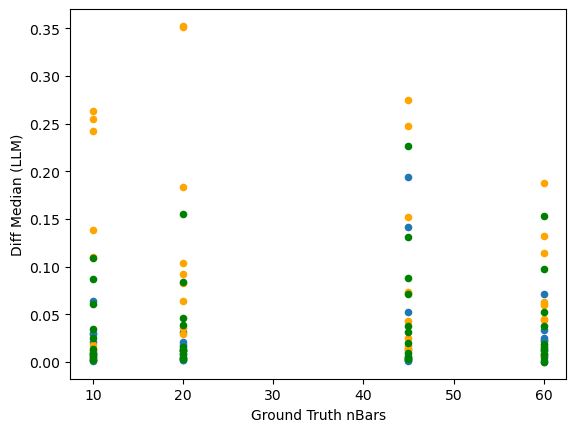

In [60]:
ax = da1.plot(x='Ground Truth nBars', y='Diff Median (human)', kind='scatter')
da2.plot(x='Ground Truth nBars', y='Diff Median (human)', kind='scatter', color='orange', ax=ax)
dl.plot(x='Ground Truth nBars', y='Diff Median (LLM)', kind='scatter', color='green', ax=ax)

In [61]:
# first annotator
b1 = da1.groupby('Ground Truth nBars')['Diff Median (human)'].median().to_frame()
b1 = b1.rename(columns={'Diff Median (human)':'Diff Median (annotator1)'})
# 2nd annotator
b2 = da2.groupby('Ground Truth nBars')['Diff Median (human)'].median().to_frame()
b2 = b2.rename(columns={'Diff Median (human)':'Diff Median (annotator2)'})
# 3rd annotator
bl = dl.groupby('Ground Truth nBars')['Diff Median (LLM)'].median().to_frame()

dfb = b1.join(b2).join(bl)
dfb

,Diff Median (annotator1),Diff Median (annotator2),Diff Median (LLM)
Ground Truth nBars,,,
10,0.007778,0.063833,0.019568
20,0.010302,0.087342,0.014199
45,0.005901,0.057266,0.034463
60,0.017487,0.059857,0.017069


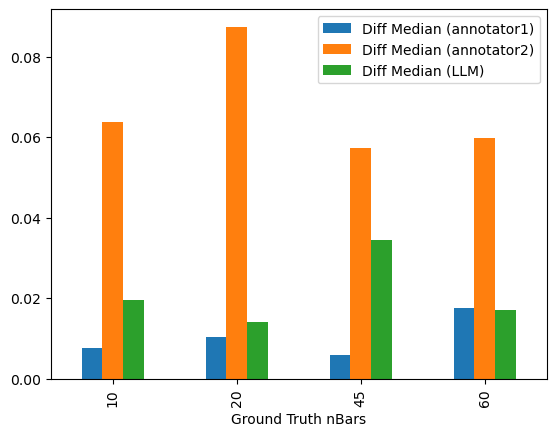

In [62]:
ax = dfb.plot(kind='bar')


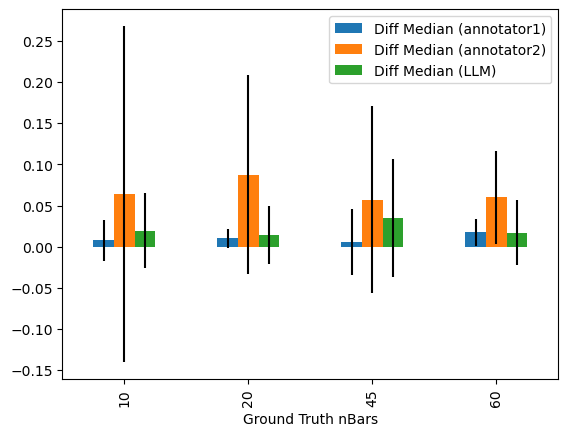

In [63]:
# plot errorbars
errorbars = []
for arr,flag in zip([da1,da2,dl], ['Diff Median (human)','Diff Median (human)','Diff Median (LLM)']):
    q1 = arr.groupby('Ground Truth nBars')[flag].quantile(0.25)
    q3 = arr.groupby('Ground Truth nBars')[flag].quantile(0.75)
    iqr_d = q3-q1
    errorbars.append(iqr_d)
# q1 = da1.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.25)
# q3 = da1.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.75)
# iqr_da1 = q3-q1
# #ax.errorbar(dfb.index.values, dfb['Diff Median (annotator1)'].values, iqr_da1.values)
# q1 = da2.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.25)
# q3 = da2.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.75)
# iqr_da2 = q3-q1
# # llm
# q1 = dl.groupby('Ground Truth nBars')['Diff Median (LLM)'].quantile(0.25)
# q3 = dl.groupby('Ground Truth nBars')['Diff Median (LLM)'].quantile(0.75)
# iqr_dl = q3-q1

ax = dfb.plot(kind='bar', yerr = errorbars) #[iqr_da1,iqr_da2,iqr_dl])


So, pretty big variation across all of these, but not sure how much is real variation and how much is the fact that each of these has small number statistics (10 data points).

In [64]:
dfb.index.values, dfb['Diff Median (annotator1)'].values, errorbars[0].values

(array([10, 20, 45, 60]),
 array([0.00777812, 0.01030201, 0.00590075, 0.01748726]),
 array([0.02471799, 0.01168004, 0.03994086, 0.01617996]))

### Median vs. number of Gaussians

In [65]:
dfbg = df2.copy()[df2['Ground Truth nBars'].isin([50])]
# make differences
diffa_bg = np.abs(dfbg['Ground Truth Median']-dfbg['Human median (draw)'])
diffl_bg = np.abs(dfbg['Ground Truth Median']-dfbg['LLM Median'])

dfbg['Diff Median (human)'] = diffa_bg
dfbg['Diff Median (LLM)'] = diffl_bg

In [66]:
dfbg.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int),Diff Median (human),Diff Median (LLM)
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,0.055,1,0.000841,0.000572
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,0.485,3,0.021338,0.006189
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50,2,-0.600,2,0.051081,0.158364
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50,1,-0.050,1,0.006579,0.128007
13,annotator1,id_0075.jpeg,2,-0.690,-0.694032,2,-0.672896,50,1,-0.700,1,0.021136,0.027104


In [67]:
da1_bg = dfbg[dfbg['annotators']=='annotator1']
da2_bg = dfbg[dfbg['annotators']=='annotator2']
dl_bg = da1_bg.copy()

# ax = da1_bg.plot(x='Ground Truth nGaussians', y='Diff Median (human)', kind='scatter')
# da2_bg.plot(x='Ground Truth nGaussians', y='Diff Median (human)', kind='scatter', color='orange', ax=ax)
# dl_bg.plot(x='Ground Truth nGaussians', y='Diff Median (LLM)', kind='scatter', color='green', ax=ax)

# scatter plot not as useful

In [68]:
# first annotator
b1_bg = da1_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].median().to_frame()
b1_bg = b1_bg.rename(columns={'Diff Median (human)':'Diff Median (annotator1)'})
# 2nd annotator
b2_bg = da2_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].median().to_frame()
b2_bg = b2_bg.rename(columns={'Diff Median (human)':'Diff Median (annotator2)'})
# 3rd annotator
bl_bg = dl_bg.groupby('Ground Truth nGaussians')['Diff Median (LLM)'].median().to_frame()

dfb_bg = b1_bg.join(b2_bg).join(bl_bg)
dfb_bg

,Diff Median (annotator1),Diff Median (annotator2),Diff Median (LLM)
Ground Truth nGaussians,,,
1,0.002837,0.008822,0.013541
2,0.012598,0.085500,0.018076
3,0.004728,0.036113,0.007785
5,0.036843,0.077561,0.035361


<Axes: xlabel='Ground Truth nGaussians'>

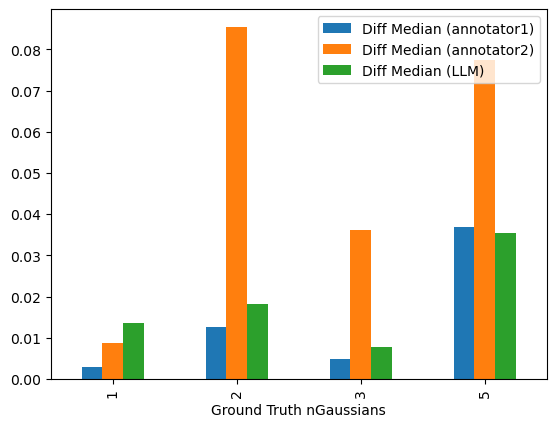

In [69]:
dfb_bg.plot(kind='bar')

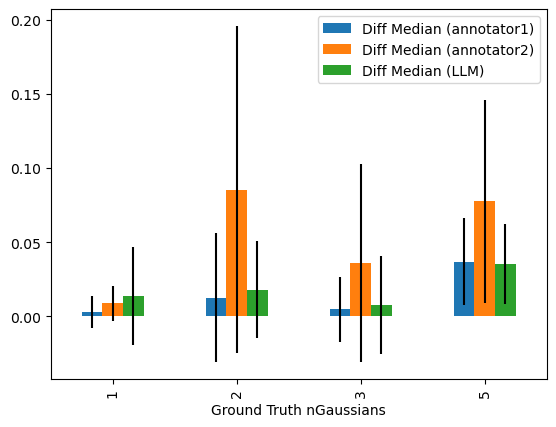

In [70]:
# plot errorbars
errorbars_bg = []
for arr,flag in zip([da1_bg,da2_bg,dl_bg], ['Diff Median (human)','Diff Median (human)','Diff Median (LLM)']):
    q1 = arr.groupby('Ground Truth nGaussians')[flag].quantile(0.25)
    q3 = arr.groupby('Ground Truth nGaussians')[flag].quantile(0.75)
    iqr_d = q3-q1
    errorbars_bg.append(iqr_d)

ax = dfb_bg.plot(kind='bar', yerr = errorbars_bg)

Same deal here with error bars and sample sizes.   Try with mean/STD:

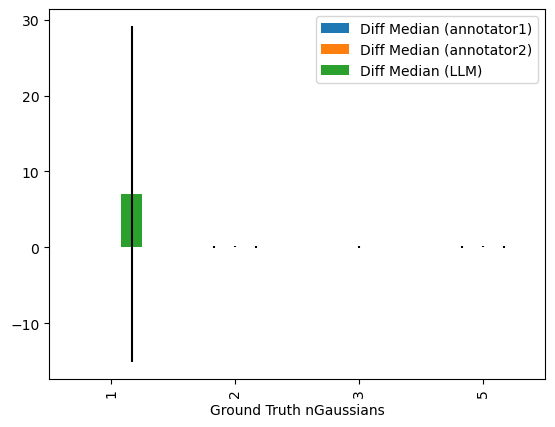

In [72]:
# first annotator
b1_bg2 = da1_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].mean().to_frame()
b1_bg2 = b1_bg2.rename(columns={'Diff Median (human)':'Diff Median (annotator1)'})
# 2nd annotator
b2_bg2 = da2_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].mean().to_frame()
b2_bg2 = b2_bg2.rename(columns={'Diff Median (human)':'Diff Median (annotator2)'})
# 3rd annotator
bl_bg2 = dl_bg.groupby('Ground Truth nGaussians')['Diff Median (LLM)'].mean().to_frame()

dfb_bg2 = b1_bg2.join(b2_bg2).join(bl_bg2)
#dfb_bg2

errorbars_bg2 = []
for arr,flag in zip([da1_bg,da2_bg,dl_bg], ['Diff Median (human)','Diff Median (human)','Diff Median (LLM)']):
    s1 = arr.groupby('Ground Truth nGaussians')[flag].std()
    errorbars_bg2.append(s1)

ax = dfb_bg2.plot(kind='bar', yerr = errorbars_bg2)

As expected, no big difference between these errorbars and IQR stuffs.

### Changes with Number of Gaussians

In [74]:
dfg = df2.copy()[df2['Ground Truth nBars'].isin([50])]
# make differences
diffa_g = np.abs(dfg['Ground Truth nGaussians']-dfg['Human nGaussians'])
diffl_g = np.abs(dfg['Ground Truth nGaussians']-dfg['LLM nGaussians (int)'])
if include_fewshot:
    difflfs_g = np.abs(dfg['Ground Truth nGaussians']-dfg['LLM nGaussians (int) FewShot'])
if include_mini:
    difflm_g = np.abs(dfg['Ground Truth nGaussians']-dfg['LLM nGaussians (int) Mini'])

dfg['Diff nGaussians (human)'] = diffa_g
dfg['Diff nGaussians (LLM)'] = diffl_g
if include_fewshot:
    dfg['Diff nGaussians (LLM) FewShot'] = difflfs_g
if include_mini:
    dfg['Diff nGaussians (LLM) Mini'] = difflm_g

In [455]:
dfg.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM nGaussians FewShot,...,LLM Median,LLM Median FewShot,LLM Median Mini,LLM nGaussians (int),LLM nGaussians (int) FewShot,LLM nGaussians (int) Mini,Diff nGaussians (human),Diff nGaussians (LLM),Diff nGaussians (LLM) FewShot,Diff nGaussians (LLM) Mini
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,1,...,0.055,0.055,0.055,1,1,1,0,0,0,0
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,1,...,0.490,0.470,0.480,1,1,3,2,0,0,2
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50,2,2,...,-0.750,-0.600,-0.600,2,2,2,0,0,0,0
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50,1,1,...,0.000,0.000,-0.100,1,1,1,0,0,0,0
13,annotator1,id_0075.jpeg,2,-0.690,-0.694032,2,-0.672896,50,3,1,...,-0.700,-0.740,-0.680,1,1,1,0,1,1,1


In [76]:
da1_g = dfg[dfg['annotators']=='annotator1']
da2_g = dfg[dfg['annotators']=='annotator2']
dl_g = da1_g.copy()

In [77]:
# first annotator
b1_g = da1_g.groupby('Ground Truth nGaussians')['Diff nGaussians (human)'].median().to_frame()
b1_g = b1_g.rename(columns={'Diff Median (human)':'Diff nGaussians (annotator1)'})
# 2nd annotator
b2_g = da2_g.groupby('Ground Truth nGaussians')['Diff nGaussians (human)'].median().to_frame()
b2_g = b2_g.rename(columns={'Diff nGaussians (human)':'Diff nGaussians (annotator2)'})
# 3rd annotator = LLM (regular)
bl_g = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM)'].median().to_frame()
# 4th annotator = LLM with fewshot
if include_fewshot:
    blfs_g = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM) FewShot'].median().to_frame()

dfb_g = b1_g.join(b2_g).join(bl_g)
if include_fewshot:
    dfb_g = dfb_g.join(blfs_g)
dfb_g

,Diff nGaussians (human),Diff nGaussians (annotator2),Diff nGaussians (LLM)
Ground Truth nGaussians,,,
1,0.0,0.0,0.0
2,0.0,1.0,1.0
3,1.0,1.0,1.0
5,2.0,3.0,3.0


<Axes: xlabel='Ground Truth nGaussians'>

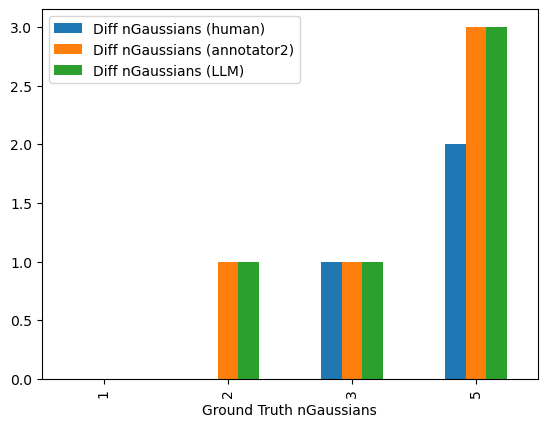

In [78]:
dfb_g.plot(kind='bar')

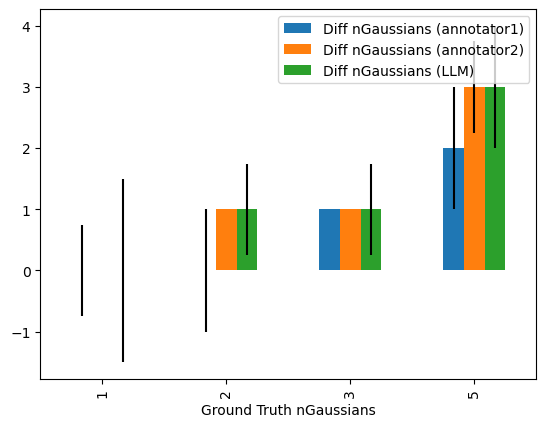

In [79]:
# first annotator
b1_g2 = da1_g.groupby('Ground Truth nGaussians')['Diff nGaussians (human)'].median().to_frame()
b1_g2 = b1_g2.rename(columns={'Diff nGaussians (human)':'Diff nGaussians (annotator1)'})
# 2nd annotator
b2_g2 = da2_g.groupby('Ground Truth nGaussians')['Diff nGaussians (human)'].median().to_frame()
b2_g2 = b2_g2.rename(columns={'Diff nGaussians (human)':'Diff nGaussians (annotator2)'})
# 3rd annotator
bl_g2 = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM)'].median().to_frame()
# 4th annotator = LLM with fewshot
if include_fewshot:
    blfs_g2 = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM) FewShot'].median().to_frame()
# 5th annotator = LLM with mini
if include_mini:
    blm_g2 = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM) Mini'].median().to_frame()

arrays = [da1_g,da2_g,dl_g]
names = ['Diff nGaussians (human)','Diff nGaussians (human)','Diff nGaussians (LLM)']

dfb_g2 = b1_g2.join(b2_g2).join(bl_g2)
if include_fewshot:
    dfb_g2 = dfb_g2.join(blfs_g2)
    arrays.append(dl_g)
    names.append('Diff nGaussians (LLM) FewShot')
if include_mini:
    dfb_g2 = dfb_g2.join(blm_g2)
    arrays.append(dl_g)
    names.append('Diff nGaussians (LLM) Mini')
#dfb_bg2

errorbars_g2 = []
for arr,flag in zip(arrays, names):
    q1 = arr.groupby('Ground Truth nGaussians')[flag].quantile(0.25)
    q3 = arr.groupby('Ground Truth nGaussians')[flag].quantile(0.75)
    iqr_d = q3-q1
    errorbars_g2.append(iqr_d)

ax = dfb_g2.plot(kind='bar', yerr = errorbars_g2)

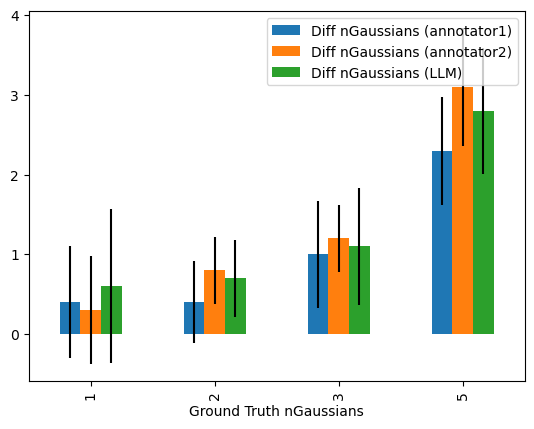

In [81]:
#### MEAN

# first annotator
b1_g2 = da1_g.groupby('Ground Truth nGaussians')['Diff nGaussians (human)'].mean().to_frame()
b1_g2 = b1_g2.rename(columns={'Diff nGaussians (human)':'Diff nGaussians (annotator1)'})
# 2nd annotator
b2_g2 = da2_g.groupby('Ground Truth nGaussians')['Diff nGaussians (human)'].mean().to_frame()
b2_g2 = b2_g2.rename(columns={'Diff nGaussians (human)':'Diff nGaussians (annotator2)'})
# 3rd annotator
bl_g2 = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM)'].mean().to_frame()
# 4th annotator
if include_fewshot:
    blfs_g2 = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM) FewShot'].mean().to_frame()
# 5th annotator = LLM with mini
if include_mini:
    blm_g2 = dl_g.groupby('Ground Truth nGaussians')['Diff nGaussians (LLM) Mini'].mean().to_frame()

arrays = [da1_g,da2_g,dl_g]
names = ['Diff nGaussians (human)','Diff nGaussians (human)','Diff nGaussians (LLM)']

dfb_g2 = b1_g2.join(b2_g2).join(bl_g2)
if include_fewshot:
    dfb_g2 = dfb_g2.join(blfs_g2)
    arrays.append(dl_g)
    names.append('Diff nGaussians (LLM) FewShot')
if include_mini:
    dfb_g2 = dfb_g2.join(blm_g2)
    arrays.append(dl_g)
    names.append('Diff nGaussians (LLM) Mini')
#dfb_bg2

errorbars_g2 = []
for arr,flag in zip(arrays,names):
    s = arr.groupby('Ground Truth nGaussians')[flag].std()
    errorbars_g2.append(s)

ax = dfb_g2.plot(kind='bar', yerr = errorbars_g2)

So, I don't think fewshot makes a difference.

In [441]:
dir_api_fewshot

'./example_hists/LLM_outputs/chatgpt_api_fewshot2/'